In [ ]:
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images"
from google.colab import drive
import os

# mount drive
drive.mount('/content/drive', force_remount=True)

basedir = "/content/drive/MyDrive/Colab Notebooks/visualintelligence/CNN"
#basedir = "" # for local execution

# install requirements in the parent folder
requirements_path = "'/content/drive/MyDrive/Colab Notebooks/visualintelligence/requirements.txt'"
!pip install -r {requirements_path}

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.io.image import decode_jpeg, read_file
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
from sklearn.model_selection import StratifiedKFold
import random
from PIL import Image
import torch.multiprocessing as mp
from functools import lru_cache
from torchvision.io import read_image, ImageReadMode
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from collections import OrderedDict
from functools import lru_cache
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from zipfile import ZipFile
from functools import lru_cache
import json

In [ ]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

import multiprocessing

num_cores = min(multiprocessing.cpu_count(), 4)
print(f"Number of cores: {num_cores}")

Using cuda
Number of cores: 2


In [ ]:
ADENOCARCINOMA = "adenocarcinoma"
SQUAMOUS_CELL_CARCINOMA = "squamous_cell_carcinoma"
BENIGN = "benign"

class_0 = BENIGN
class_1 = ADENOCARCINOMA

In [ ]:
with ZipFile(basedir+"dataset.zip", "r") as zip_ref:
    zip_ref.extractall()

# move folders to the right place
os.makedirs("dataset", exist_ok=True)
shutil.move(ADENOCARCINOMA, "dataset")
shutil.move(SQUAMOUS_CELL_CARCINOMA, "dataset")
shutil.move(BENIGN, "dataset")

'dataset/benign'

Number of files in benign folder: 5000
Number of files in adenocarcinoma folder: 5000
   filename   class
0  2266.jpg  benign
1  0470.jpg  benign
2  0984.jpg  benign
3  2317.jpg  benign
4  2849.jpg  benign


Text(0.5, 1.0, 'Class distribution')

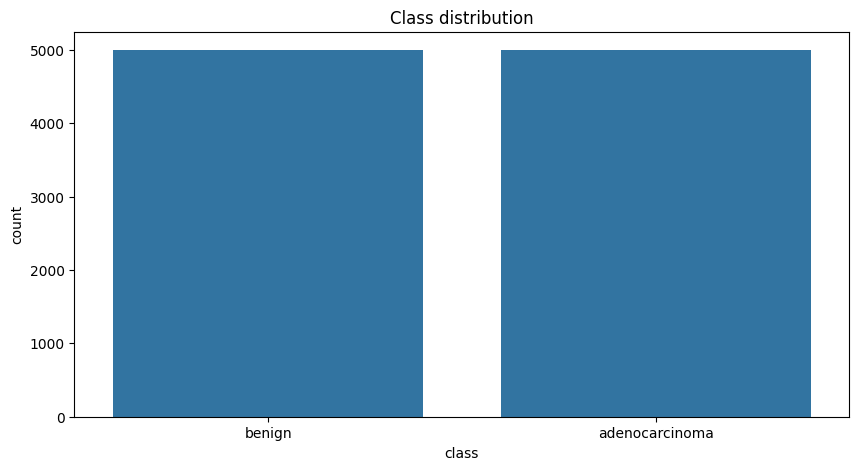

In [ ]:
# Creating lists for dataframe construction
allFilesClass0 = os.listdir(f"dataset/{class_0}")
allFilesClass1 = os.listdir(f"dataset/{class_1}")

print(f"Number of files in {class_0} folder: {len(allFilesClass0)}")
print(f"Number of files in {class_1} folder: {len(allFilesClass1)}")

df = pd.DataFrame(columns=["filename", "class"])
df["filename"] = allFilesClass0 + allFilesClass1
df["class"] = [class_0] * len(allFilesClass0) + [class_1] * len(allFilesClass1)

# Displaying the dataframe
print(df.head())

# Displaying the class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="class")
plt.title("Class distribution")

In [ ]:
# Performing a stratified k-folds subdivision
#KFOLDS = 10
#skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
#skf.get_n_splits(df["filename"], df["class"])
#
## Storing indexes to reuse them later
#train_indexes = []
#val_indexes = []
#for train_index, val_index in skf.split(df["filename"], df["class"]):
#    train_indexes.append(train_index)
#    val_indexes.append(val_index)
#
#train_splits = pd.DataFrame(columns=[f"train_{i}" for i in range(KFOLDS)])
#val_splits = pd.DataFrame(columns=[f"val_{i}" for i in range(KFOLDS)])
#
#for i in range(KFOLDS):
#    train_splits[f"train_{i}"] = train_indexes[i]
#    val_splits[f"val_{i}"] = val_indexes[i]
#
## Saving the splits
#train_splits.to_csv(basedir + "train_splits.csv", index=False)
#val_splits.to_csv(basedir + "val_splits.csv", index=False)

In [ ]:
# recover the splits
train_splits = pd.read_csv(basedir + "train_splits.csv")
val_splits = pd.read_csv(basedir + "val_splits.csv")

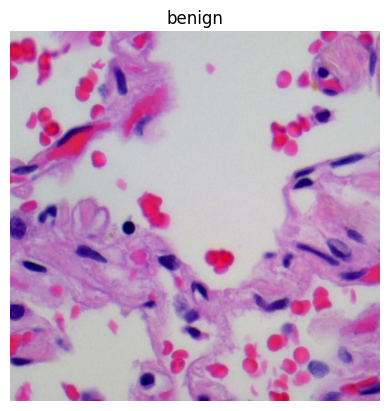

Image size: (768, 768)
Image mode: RGB


In [ ]:
# image inspection

random.seed(42)
idx = random.choice(range(len(df)))
image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
plt.imshow(image)


plt.title(df.iloc[idx]["class"])
plt.axis("off")
plt.show()

# print metadata
print(f"Image size: {image.size}")
print(f"Image mode: {image.mode}")

In [ ]:
# Finding all the unique shapes of the images inside the dataset
#shapes = []
#for idx in tqdm(range(len(df))):
#    image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
#    shapes.append(image.size)
#
#shapes = np.array(shapes)
#unique_shapes = np.unique(shapes, axis=0)
#print(f"Unique shapes: {unique_shapes}")

In [ ]:
class LungCancerDataset(Dataset):
    def __init__(self, df, folder_path, transform=None, cache_size=800):
        self.df = df
        self.folder_path = folder_path
        self.transform = transform
        self.cache_size = cache_size
        self.cache = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx in self.cache:
            image, label = self.cache[idx]
        else:
            img_name = self.df.iloc[idx]["filename"]
            img_class = self.df.iloc[idx]["class"]
            img_path = os.path.join(self.folder_path, img_class, img_name)

            # Load and cache image
            #image = Image.open(img_path).convert("RGB")
            #image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255
            data = read_file(img_path)
            image = decode_jpeg(data, device=device).float()  / 255
            label = 1 if img_class == ADENOCARCINOMA else 0
            label = torch.tensor(label, dtype=torch.long)

            # Add to cache
            if len(self.cache) < self.cache_size:
                self.cache[idx] = (image, label)

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
TARGET_IMAGE_SIZE = 768

In [ ]:

def calculate_fold_stats(df, train_idx, image_size=TARGET_IMAGE_SIZE):
    """Calculate mean and std for a specific fold"""
    print(f"Calculating dataset statistics for fold {train_idx}")
    print(f"Number of images: {len(train_idx)}")
    transform = transforms.Compose(
        [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
    )

    # Create dataset for train fold
    train_df = df.iloc[train_idx]
    train_dataset = LungCancerDataset(train_df, "dataset", transform=transform)

    # Calculate mean and std
    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_batches = 0

    for data, _ in tqdm(
        DataLoader(
            train_dataset, batch_size=64,
        ),
        desc="Calculating dataset statistics",
    ):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [ ]:
def create_dataloaders(
    df, train_idx, val_idx, mean, std, batch_size=32, image_size=TARGET_IMAGE_SIZE
):
    """Create normalized dataloaders for a specific fold"""

    # Define transforms
    train_transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    # Create datasets
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_dataset = LungCancerDataset(train_df, "dataset", transform=train_transform)
    val_dataset = LungCancerDataset(val_df, "dataset", transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [ ]:
# Example usage for each fold
#fold_stats = {}
#for fold in range(KFOLDS):
#    print(f"Processing fold {fold}")
#    train_idx = train_splits[f"train_{fold}"].values
#    val_idx = val_splits[f"val_{fold}"].values
#
#    # Calculate statistics for this fold
#    mean, std = calculate_fold_stats(df, train_idx)
#    fold_stats[fold] = {"mean": mean, "std": std}
#
#    # Create dataloaders with fold-specific normalization
#    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
#
#    # Print fold statistics
#    print(f"Fold {fold} statistics:")
#    print(f"Mean: {mean}")
#    print(f"Std: {std}\n")
#
## Save fold statistics
#with open("fold_stats.json", "w") as f:
#    json.dump(
#        {
#            k: {"mean": v["mean"].tolist(), "std": v["std"].tolist()}
#            for k, v in fold_stats.items()
#        },
#        f,
#    )

In [ ]:
# load fold statistics
with open(basedir+"fold_stats.json", "r") as f:
    fold_stats = json.load(f)
print(fold_stats)

{'0': {'mean': [0.7064047455787659, 0.5720739960670471, 0.8341714143753052], 'std': [0.1673128455877304, 0.20926183462142944, 0.11783168464899063]}, '1': {'mean': [0.7064012885093689, 0.5720331072807312, 0.8340111970901489], 'std': [0.1673007309436798, 0.20920173823833466, 0.11779171973466873]}, '2': {'mean': [0.7062825560569763, 0.5720421671867371, 0.834133505821228], 'std': [0.167218416929245, 0.20908495783805847, 0.11773984134197235]}, '3': {'mean': [0.7064064145088196, 0.5721913576126099, 0.8341804146766663], 'std': [0.16709156334400177, 0.20918165147304535, 0.11760079115629196]}, '4': {'mean': [0.7066220641136169, 0.5721625685691833, 0.8340489268302917], 'std': [0.1670798808336258, 0.20912280678749084, 0.11775249242782593]}, '5': {'mean': [0.7067297101020813, 0.5721986889839172, 0.8341744542121887], 'std': [0.16703304648399353, 0.20902416110038757, 0.11764462292194366]}, '6': {'mean': [0.7062463760375977, 0.5719467401504517, 0.8339688181877136], 'std': [0.16714131832122803, 0.2091

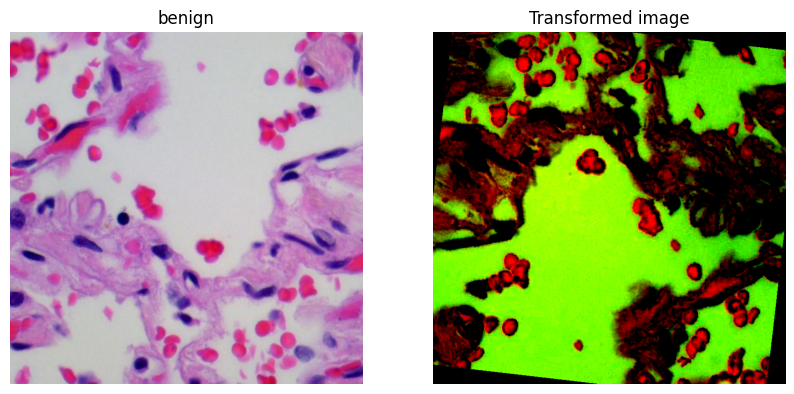

In [ ]:
# Display a random image from the dataset
random.seed(42)
idx = random.choice(range(len(df)))
image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title(df.iloc[idx]["class"])
ax[0].axis("off")

# Display the image after applying the transforms
transform = transforms.Compose(
    [
        transforms.Resize((TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=fold_stats["0"]["mean"], std=fold_stats["0"]["std"]),
    ]
)

transformed_image = transform(image)
transformed_image = transformed_image.permute(1, 2, 0)

ax[1].imshow(transformed_image)
ax[1].set_title("Transformed image")
ax[1].axis("off")
plt.show()

In [ ]:
# take the data from the first fold
train_idx = train_splits["train_0"].values
val_idx = val_splits["val_0"].values
mean = fold_stats["0"]["mean"]
std = fold_stats["0"]["std"]

# Create dataloaders with fold-specific normalization
train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

# check len of train and val loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Val loader length: {len(val_loader)}")

Train loader length: 282
Val loader length: 32


In [ ]:
# benchmark the dataloaders
def benchmark_dataloader(loader, num_epochs=1):
    for epoch in range(num_epochs):
        for i, (data, target) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
            pass

benchmark_dataloader(train_loader, num_epochs=1)
benchmark_dataloader(val_loader, num_epochs=1)

Epoch 0:   0%|          | 0/282 [00:00<?, ?it/s]

KeyboardInterrupt: 

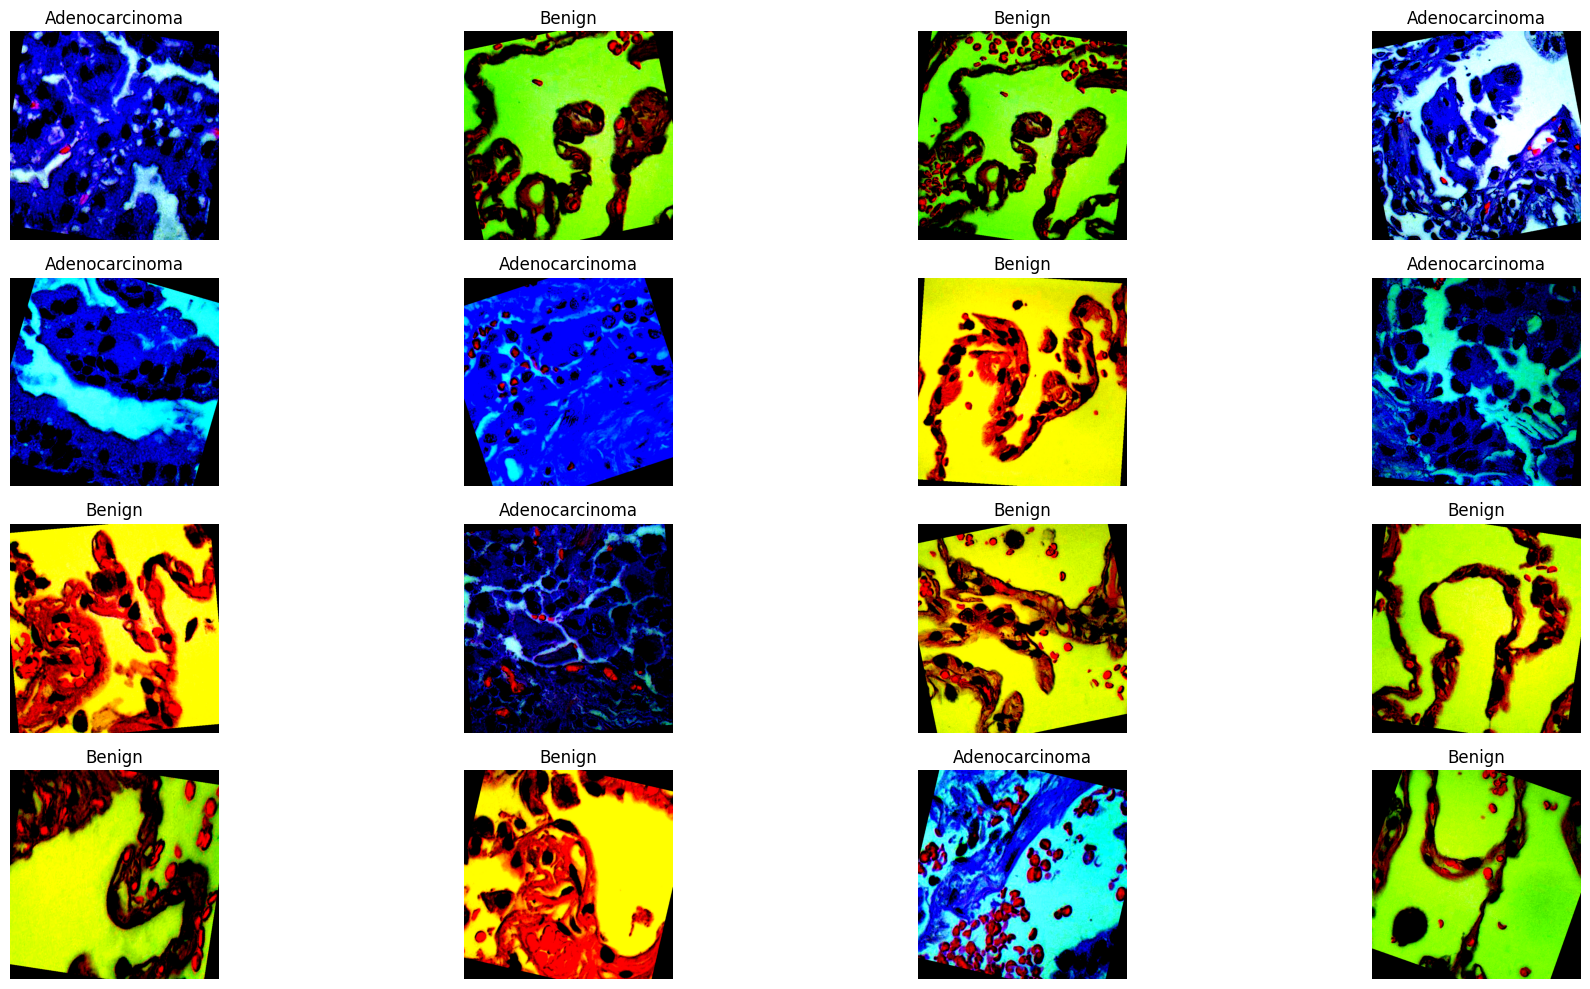

In [ ]:
# show the content of the first batch
for i_batch, (images, labels) in enumerate(train_loader):
    fig, axes = plt.subplots(4, 4, figsize=(20, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].permute(1, 2, 0).to("cpu"))
        ax.axis("off")
        ax.set_title("Adenocarcinoma" if labels[i] == 1 else "Benign")
    plt.tight_layout()
    plt.show()
    break

In [ ]:
# Create a simple CNN model
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 4, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.Dropout(0.2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4, 2),
        )

    def forward(self, x):
        print(f"forward: {x.shape}")
        x = self.conv1(x)
        print(f"conv1: {x.shape}")
        x = self.global_pool(x)
        print(f"global_pool: {x.shape}")
        x = torch.flatten(x, 1)
        print(f"flatten: {x.shape}")
        x = self.classifier(x)
        print(f"classifier: {x.shape}")
        return x

"""
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
conv1: torch.Size([1, 4, 384, 384])
global_pool: torch.Size([1, 4, 1, 1])
flatten: torch.Size([1, 4])
classifier: torch.Size([1, 2])
tensor([[ 0.0633, -0.6436]])
forward: torch.Size([1, 3, 768, 768])
conv1: torch.Size([1, 4, 384, 384])
global_pool: torch.Size([1, 4, 1, 1])
flatten: torch.Size([1, 4])
classifier: torch.Size([1, 2])
"""

# Instantiate model
model = ImageClassifier().to(device)

In [ ]:
# getting a single image from the batch
images, labels = next(iter(train_loader))
print(f"Labels : {labels}")

print(f"Images shape: {images.shape}")
image = images[0].unsqueeze(0).to(device)
label = labels[0].unsqueeze(0).to(device)

# Forward pass
model.eval()
with torch.inference_mode():
    output = model(image)
    print(output)

# check the model summary
print(
    summary(
        model, input_size=(1, 3, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), device=device
    )
)

Labels : tensor([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0])
Images shape: torch.Size([32, 3, 768, 768])
forward: torch.Size([1, 3, 768, 768])
conv1: torch.Size([1, 4, 384, 384])
global_pool: torch.Size([1, 4, 1, 1])
flatten: torch.Size([1, 4])
classifier: torch.Size([1, 2])
tensor([[ 0.1310, -0.2274]], device='cuda:0')
forward: torch.Size([1, 3, 768, 768])
conv1: torch.Size([1, 4, 384, 384])
global_pool: torch.Size([1, 4, 1, 1])
flatten: torch.Size([1, 4])
classifier: torch.Size([1, 2])
Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 4, 384, 384]          --
│    └─Conv2d: 2-1                       [1, 4, 384, 384]          304
│    └─ReLU: 2-2                         [1, 4, 384, 384]          --
│    └─BatchNorm2d: 2-3                  [1, 4, 384, 384]          8
│    └─Dropout: 2-4  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("profile"),
) as prof:
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        prof.step()
        if prof.step_num == 40:
            break

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
print("Profiling finished.")


forward: torch.Size([32, 3, 768, 768])
conv1: torch.Size([32, 4, 384, 384])
global_pool: torch.Size([32, 4, 1, 1])
flatten: torch.Size([32, 4])
classifier: torch.Size([32, 2])
forward: torch.Size([32, 3, 768, 768])
conv1: torch.Size([32, 4, 384, 384])
global_pool: torch.Size([32, 4, 1, 1])
flatten: torch.Size([32, 4])
classifier: torch.Size([32, 2])
forward: torch.Size([32, 3, 768, 768])
conv1: torch.Size([32, 4, 384, 384])
global_pool: torch.Size([32, 4, 1, 1])
flatten: torch.Size([32, 4])
classifier: torch.Size([32, 2])
forward: torch.Size([32, 3, 768, 768])
conv1: torch.Size([32, 4, 384, 384])
global_pool: torch.Size([32, 4, 1, 1])
flatten: torch.Size([32, 4])
classifier: torch.Size([32, 2])
forward: torch.Size([32, 3, 768, 768])
conv1: torch.Size([32, 4, 384, 384])
global_pool: torch.Size([32, 4, 1, 1])
flatten: torch.Size([32, 4])
classifier: torch.Size([32, 2])
forward: torch.Size([32, 3, 768, 768])
conv1: torch.Size([32, 4, 384, 384])
global_pool: torch.Size([32, 4, 1, 1])
flatt

In [ ]:
# Defining the operations to do in a training step
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    # Put model in train mode
    model.train()
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    # Loop through DataLoader batches
    for _, (img, label) in enumerate(dataloader):
        # Send data to target device
        X = img.to(device)
        y = label.to(device)
        # Forward pass
        y_pred = model(X)
        # Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss backward
        loss.backward()
        # Optimizer step
        optimizer.step()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
# Defining the operations to do in a validation step
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    # Put model in eval mode
    model.eval()
    # Setup validation loss and validation accuracy values
    val_loss, val_acc = 0, 0
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for _, (img, label) in enumerate(dataloader):
            # Send data to target device
            X = img.to(device)
            y = label.to(device)
            # Forward pass
            val_pred_logits = model(X)
            # Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()
            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)
    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [ ]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 50,
    split: int = 0,
    patience: int = 5,  # Early stopping patience
    min_delta: float = 0.001,  # Minimum improvement required
):
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Initialize early stopping variables
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=3, verbose="True"
    )

    # Initialize tracking for best model
    best_val = 0

    # Training loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )

        val_loss, val_acc = val_step(
            model=model, dataloader=val_dataloader, loss_fn=loss_fn
        )

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Save best model
        if val_acc > best_val:
            best_val = val_acc
            checkpoint = {
                "model": ImageClassifier(),
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            checkpoint_name = basedir+"checkpoint_" + str(split) + ".pth"
            torch.save(checkpoint, checkpoint_name)

        # Print training progress
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return results

In [ ]:
## These lines take a lot of time; you will load the trained model in the following

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set hyperparameters
NUM_EPOCHS = 50
PATIENCE = 5
MIN_DELTA = 0.001

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# model = model.to(device)

# Train model with early stopping and LR scheduling
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    split=0,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
## These are the results from the previous step; you will load the results in the following

# Extract train and validation loss and accuracy at each epoch
results = dict(list(model_results.items()))

# Get the loss values of the results dictionary (training and validation)
train_loss = results["train_loss"]
val_loss = results["val_loss"]

# Get the accuracy values of the results dictionary (training and validation)
train_acc = results["train_acc"]
val_acc = results["val_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))
print("epochs: ", epochs)

In [ ]:
## Save results in a csv
results_df = pd.DataFrame(
    columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
)
results_df["train_loss"] = train_loss
results_df["val_loss"] = val_loss
results_df["train_acc"] = train_acc
results_df["val_acc"] = val_acc
results_df["epochs"] = epochs
results_df_name = basedir +"results_df_" + str(0) + ".csv"
results_df.to_csv(results_df_name)

print("df: ", results_df)

df:      train_loss  val_loss  train_acc   val_acc  epochs
0     0.323278  0.153151   0.892730  0.966797       0
1     0.204483  0.123550   0.941600  0.966797       1
2     0.184078  0.117169   0.935284  0.960938       2
3     0.175619  0.111145   0.933289  0.960938       3
4     0.171186  0.108752   0.929632  0.953125       4
5     0.175031  0.112282   0.930962  0.960938       5
6     0.168760  0.102316   0.929743  0.960938       6
7     0.166767  0.101277   0.931627  0.955078       7
8     0.158081  0.105454   0.935395  0.964844       8
9     0.161907  0.096511   0.931294  0.958008       9
10    0.154683  0.118737   0.933178  0.966797      10
11    0.157603  0.092353   0.935505  0.959961      11
12    0.166128  0.102429   0.929965  0.962891      12
13    0.164632  0.110394   0.931738  0.966797      13
14    0.158084  0.094321   0.934286  0.962891      14
15    0.153372  0.093236   0.935395  0.956055      15
16    0.160491  0.090894   0.927637  0.958984      16
17    0.150898  0.09028

In [ ]:
results_from_csv = pd.read_csv(basedir+"results_df_0.csv")

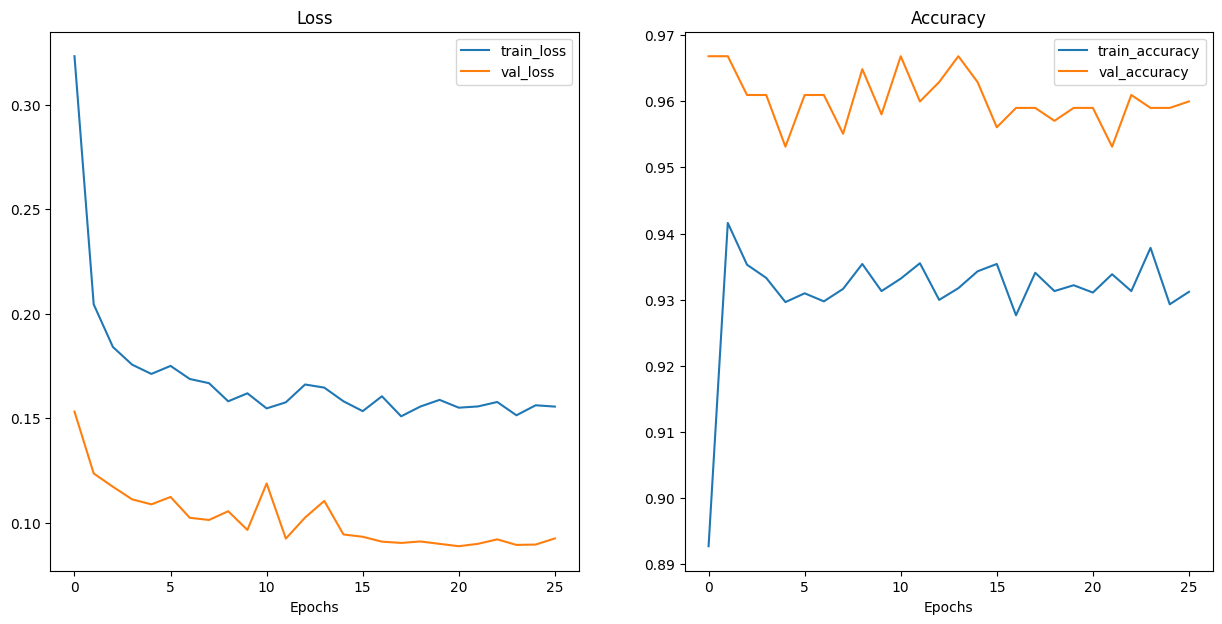

In [ ]:

# Setup a plot
plt.figure(figsize=(15,7))

# Plot loss
plt.subplot(1,2,1)
plt.plot(results_from_csv["epochs"],results_from_csv["train_loss"],label="train_loss")
plt.plot(results_from_csv["epochs"],results_from_csv["val_loss"],label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(results_from_csv["epochs"],results_from_csv["train_acc"],label="train_accuracy")
plt.plot(results_from_csv["epochs"],results_from_csv["val_acc"],label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
## You can find the model and result corresponding to each fold in the files inside the directory

# Continue the training and validation of the model for all the other folds
for i in range(1,10):
    # Keeping the split
    train_str = "train_"+str(i)
    val_str = "val_"+str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]

    # Create dataloaders with fold-specific normalization
    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()
    # Train model
    model_results = train(model=model,
                          train_dataloader=train_loader,
                          val_dataloader=val_loader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=NUM_EPOCHS,
                          split=i)
    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
    # Extract train and validation loss and accuracy at each epoch
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Save results in a csv
    results_df = pd.DataFrame(columns= ["train_loss","val_loss","train_acc","val_acc","epochs"])
    results_df["train_loss"] = train_loss
    results_df["val_loss"] = val_loss
    results_df["train_acc"] = train_acc
    results_df["val_acc"] = val_acc
    results_df["epochs"] = epochs
    results_df_name = basedir+"results_df_"+str(i)+".csv"
    results_df.to_csv(results_df_name)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1531 | train_acc: 0.9344 | val_loss: 0.0959 | val_acc: 0.9531
Epoch: 2 | train_loss: 0.1538 | train_acc: 0.9330 | val_loss: 0.0964 | val_acc: 0.9551
Epoch: 3 | train_loss: 0.1514 | train_acc: 0.9341 | val_loss: 0.1126 | val_acc: 0.9570
Epoch: 4 | train_loss: 0.1469 | train_acc: 0.9357 | val_loss: 0.1004 | val_acc: 0.9561
Epoch: 5 | train_loss: 0.1532 | train_acc: 0.9325 | val_loss: 0.0985 | val_acc: 0.9551
Epoch: 6 | train_loss: 0.1541 | train_acc: 0.9325 | val_loss: 0.1020 | val_acc: 0.9561
Early stopping triggered after 6 epochs
Total training time for split 1: 298.535 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1522 | train_acc: 0.9350 | val_loss: 0.0837 | val_acc: 0.9629
Epoch: 2 | train_loss: 0.1644 | train_acc: 0.9316 | val_loss: 0.0845 | val_acc: 0.9619
Epoch: 3 | train_loss: 0.1509 | train_acc: 0.9350 | val_loss: 0.0845 | val_acc: 0.9619
Epoch: 4 | train_loss: 0.1513 | train_acc: 0.9368 | val_loss: 0.0834 | val_acc: 0.9619
Epoch: 5 | train_loss: 0.1526 | train_acc: 0.9341 | val_loss: 0.0833 | val_acc: 0.9619
Epoch: 6 | train_loss: 0.1535 | train_acc: 0.9325 | val_loss: 0.0847 | val_acc: 0.9629
Early stopping triggered after 6 epochs
Total training time for split 2: 296.305 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1555 | train_acc: 0.9315 | val_loss: 0.0769 | val_acc: 0.9609
Epoch: 2 | train_loss: 0.1574 | train_acc: 0.9320 | val_loss: 0.0744 | val_acc: 0.9678
Epoch: 3 | train_loss: 0.1489 | train_acc: 0.9388 | val_loss: 0.0775 | val_acc: 0.9678
Epoch: 4 | train_loss: 0.1620 | train_acc: 0.9324 | val_loss: 0.0747 | val_acc: 0.9688
Epoch: 5 | train_loss: 0.1583 | train_acc: 0.9343 | val_loss: 0.0754 | val_acc: 0.9629
Epoch: 6 | train_loss: 0.1542 | train_acc: 0.9322 | val_loss: 0.0751 | val_acc: 0.9648
Epoch: 7 | train_loss: 0.1561 | train_acc: 0.9327 | val_loss: 0.0748 | val_acc: 0.9658
Early stopping triggered after 7 epochs
Total training time for split 3: 344.447 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1563 | train_acc: 0.9310 | val_loss: 0.0690 | val_acc: 0.9648
Epoch: 2 | train_loss: 0.1554 | train_acc: 0.9326 | val_loss: 0.0702 | val_acc: 0.9727
Epoch: 3 | train_loss: 0.1589 | train_acc: 0.9315 | val_loss: 0.0718 | val_acc: 0.9717
Epoch: 4 | train_loss: 0.1596 | train_acc: 0.9337 | val_loss: 0.0691 | val_acc: 0.9688
Epoch: 5 | train_loss: 0.1532 | train_acc: 0.9342 | val_loss: 0.0696 | val_acc: 0.9717
Epoch: 6 | train_loss: 0.1607 | train_acc: 0.9299 | val_loss: 0.0719 | val_acc: 0.9717
Early stopping triggered after 6 epochs
Total training time for split 4: 295.690 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1562 | train_acc: 0.9336 | val_loss: 0.0717 | val_acc: 0.9697
Epoch: 2 | train_loss: 0.1522 | train_acc: 0.9348 | val_loss: 0.0710 | val_acc: 0.9678
Epoch: 3 | train_loss: 0.1623 | train_acc: 0.9258 | val_loss: 0.0708 | val_acc: 0.9697
Epoch: 4 | train_loss: 0.1592 | train_acc: 0.9321 | val_loss: 0.0713 | val_acc: 0.9688
Epoch: 5 | train_loss: 0.1550 | train_acc: 0.9306 | val_loss: 0.0712 | val_acc: 0.9688
Epoch: 6 | train_loss: 0.1563 | train_acc: 0.9338 | val_loss: 0.0713 | val_acc: 0.9688
Early stopping triggered after 6 epochs
Total training time for split 5: 295.143 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1559 | train_acc: 0.9337 | val_loss: 0.0802 | val_acc: 0.9639
Epoch: 2 | train_loss: 0.1581 | train_acc: 0.9315 | val_loss: 0.0814 | val_acc: 0.9658
Epoch: 3 | train_loss: 0.1574 | train_acc: 0.9315 | val_loss: 0.0750 | val_acc: 0.9629
Epoch: 4 | train_loss: 0.1615 | train_acc: 0.9311 | val_loss: 0.0742 | val_acc: 0.9600
Epoch: 5 | train_loss: 0.1560 | train_acc: 0.9318 | val_loss: 0.0773 | val_acc: 0.9648
Epoch: 6 | train_loss: 0.1557 | train_acc: 0.9297 | val_loss: 0.0745 | val_acc: 0.9600
Epoch: 7 | train_loss: 0.1577 | train_acc: 0.9291 | val_loss: 0.0749 | val_acc: 0.9619
Epoch: 8 | train_loss: 0.1548 | train_acc: 0.9316 | val_loss: 0.0746 | val_acc: 0.9600
Early stopping triggered after 8 epochs
Total training time for split 6: 395.719 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1532 | train_acc: 0.9343 | val_loss: 0.0806 | val_acc: 0.9688
Epoch: 2 | train_loss: 0.1561 | train_acc: 0.9364 | val_loss: 0.0841 | val_acc: 0.9590
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.9333 | val_loss: 0.0815 | val_acc: 0.9688
Epoch: 4 | train_loss: 0.1499 | train_acc: 0.9359 | val_loss: 0.0840 | val_acc: 0.9639
Epoch: 5 | train_loss: 0.1529 | train_acc: 0.9341 | val_loss: 0.0806 | val_acc: 0.9688
Epoch: 6 | train_loss: 0.1555 | train_acc: 0.9303 | val_loss: 0.0855 | val_acc: 0.9609
Early stopping triggered after 6 epochs
Total training time for split 7: 296.817 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1517 | train_acc: 0.9342 | val_loss: 0.0679 | val_acc: 0.9678
Epoch: 2 | train_loss: 0.1581 | train_acc: 0.9327 | val_loss: 0.0687 | val_acc: 0.9678
Epoch: 3 | train_loss: 0.1591 | train_acc: 0.9321 | val_loss: 0.0679 | val_acc: 0.9678
Epoch: 4 | train_loss: 0.1562 | train_acc: 0.9321 | val_loss: 0.0689 | val_acc: 0.9668
Epoch: 5 | train_loss: 0.1493 | train_acc: 0.9341 | val_loss: 0.0682 | val_acc: 0.9688
Epoch: 6 | train_loss: 0.1572 | train_acc: 0.9324 | val_loss: 0.0687 | val_acc: 0.9668
Early stopping triggered after 6 epochs
Total training time for split 8: 296.853 seconds


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1575 | train_acc: 0.9295 | val_loss: 0.0835 | val_acc: 0.9629
Epoch: 2 | train_loss: 0.1560 | train_acc: 0.9321 | val_loss: 0.0832 | val_acc: 0.9629
Epoch: 3 | train_loss: 0.1590 | train_acc: 0.9294 | val_loss: 0.0833 | val_acc: 0.9629
Epoch: 4 | train_loss: 0.1554 | train_acc: 0.9305 | val_loss: 0.0874 | val_acc: 0.9639
Epoch: 5 | train_loss: 0.1521 | train_acc: 0.9332 | val_loss: 0.0837 | val_acc: 0.9629
Epoch: 6 | train_loss: 0.1517 | train_acc: 0.9342 | val_loss: 0.0892 | val_acc: 0.9639
Early stopping triggered after 6 epochs
Total training time for split 9: 296.294 seconds


In [ ]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location=torch.device(device))
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model


In [ ]:
def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Avoid division by zero
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy

def compute_metrics(model, dataloader):
    model.eval()
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            y_pred = np.concatenate((y_pred, y_pred_class.cpu().numpy()))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1

accuracies = []
f1_scores = []
# Iterate through all folds (0-9)
for i in range(10):
    model = load_checkpoint(basedir + "checkpoint_" + str(i) + ".pth")
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]
    _, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
    accuracy, f1 = compute_metrics(model, val_loader)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Accuracy for split {i}: {accuracy}")
    print(f"F1 Score for split {i}: {f1}")


mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean F1 Score: {mean_f1_score}")

<ipython-input-23-2e9a3a1425d2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath,map_location=torch.device(device))


Accuracy for split 0: 0.966
F1 Score for split 0: 0.9650205761316873
Accuracy for split 1: 0.956
F1 Score for split 1: 0.9544513457556936
Accuracy for split 2: 0.962
F1 Score for split 2: 0.9615384615384616
Accuracy for split 3: 0.968
F1 Score for split 3: 0.9674134419551935
Accuracy for split 4: 0.972
F1 Score for split 4: 0.9714285714285714
Accuracy for split 5: 0.969
F1 Score for split 5: 0.9685279187817258
Accuracy for split 6: 0.965
F1 Score for split 6: 0.9640287769784172
Accuracy for split 7: 0.968
F1 Score for split 7: 0.9675456389452333
Accuracy for split 8: 0.968
F1 Score for split 8: 0.967479674796748
Accuracy for split 9: 0.963
F1 Score for split 9: 0.9621289662231319
Mean Accuracy: 0.9656999999999998
Mean F1 Score: 0.9649563372534862
